In [3]:
import os
import torch
import torch.nn as nn
import dltools

In [4]:
def read_imdb(data_dir, is_train):
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test', label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels


data_dir = 'D:\python\code5\\NLP-Pytorch\Practical\imdb\\'
train_data = read_imdb(data_dir, is_train=True)
print('训练集数目：', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('标签：', y, 'review:', x[:60])

训练集数目： 25000
标签： 1 review: Bromwell High is a cartoon comedy. It ran at the same time a
标签： 1 review: Homelessness (or Houselessness as George Carlin stated) has 
标签： 1 review: Brilliant over-acting by Lesley Ann Warren. Best dramatic ho


In [5]:
train_tokens = dltools.tokenize(train_data[0], token='word')
vocab = dltools.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

(array([ 553., 2373., 6820., 4834., 2817., 1848., 1380., 1005.,  759.,
         581.,  437.,  349.,  257.,  207.,  174.,  133.,  116.,   85.,
          75.]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800, 850, 900, 950]),
 <BarContainer object of 19 artists>)

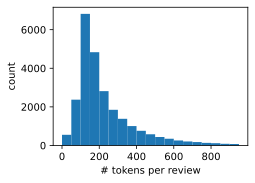

In [6]:
dltools.set_figsize()
dltools.plt.xlabel('# tokens per review')
dltools.plt.ylabel('count')
dltools.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50))

In [7]:
num_steps = 500
train_features = torch.tensor([dltools.truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


In [8]:
train_iter = dltools.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, 'y:', y.shape)
    break

print(len(train_iter))

X: torch.Size([64, 500]) y: torch.Size([64])
391


In [9]:
# 整合代码
def load_data_imdb(batch_size, num_steps=500):
    """返回数据迭代器和IMDb评论数据集的词表"""
    data_dir = dltools.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = dltools.tokenize(train_data[0], token='word')
    test_tokens = dltools.tokenize(test_data[0], token='word')
    vocab = dltools.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor(
        [dltools.truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([dltools.truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = dltools.load_array((train_features, torch.tensor(train_data[1])), batch_size)
    test_iter = dltools.load_array((test_features, torch.tensor(test_data[1])), batch_size, is_train=False)
    return train_iter, test_iter, vocab

In [22]:
import torch
import torch.nn as nn
import dltools

batch_size = 64
train_iter, test_iter, vocab = dltools.load_data_imdb(batch_size)

In [23]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [24]:
embed_size, num_hiddens, num_layers = 100, 100, 2
device = dltools.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if 'weight' in param:
                nn.init.xavier_uniform_(m._parameters[param])


net.apply(init_weights)

BiRNN(
  (embedding): Embedding(49346, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

In [25]:
glove_emedding = dltools.TokenEmbedding('glove.6b.100d')

In [26]:
embeds = glove_emedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [27]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.310, train acc 0.871, test acc 0.853
1333.2 examples/sec on [device(type='cuda', index=0)]


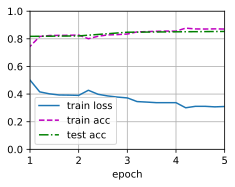

In [29]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
dltools.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, device)

In [30]:
def predict_sentiment(net, vocab, sequence):
    sequence = torch.tensor(vocab[sequence.split()], device=dltools.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [31]:
predict_sentiment(net,vocab,'the movie is so bad')

'negative'